### EDA

In [36]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import ks_2samp

In [37]:
DATA_DIR = r"C:\Users\lixin\Desktop\E1\AI_features"

meta_path = os.path.join(DATA_DIR, "merged_metadata.csv")
temp_path = os.path.join(DATA_DIR, "temporal_features.csv")

df_meta = pd.read_csv(meta_path)
df_temp = pd.read_csv(temp_path)

df = df_meta.merge(df_temp, on="video_id")
df.head()

,video_id,prompt_id,run,resolution,fps,duration_sec,aspect_ratio,model,model_config,created_at,...,smoothness,rhythm_strength,cycle_score,pause_ratio,segment_count,speed_entropy,direction_consistency,dir_hist_entropy,mean_speed,speed_std
0,V-001,1A-L-1,1,1280x720,24,8,16:9,Veo 3.1 – Fast,"{ ""resolution"": ""720p"", ""aspect_ratio"": ""16:9...",11/11/2025,...,37.452111,0.121926,1.818119,0.031414,2,2.765999,0.510251,3.556951,0.226785,0.102295
1,V-002,1A-L-1,2,1280x720,24,8,16:9,Veo 3.1 – Fast,"{ ""resolution"": ""720p"", ""aspect_ratio"": ""16:9...",11/11/2025,...,15.495925,0.184653,7.930252,0.214660,1,2.666871,0.436878,3.146965,1.298723,0.858215
2,V-003,1A-L-1,3,1280x720,24,8,16:9,Veo 3.1 – Fast,"{ ""resolution"": ""720p"", ""aspect_ratio"": ""16:9...",11/16/2025,...,1.041492,0.085367,2.397554,0.005236,10,1.995706,0.538073,3.507519,3.986171,1.610596
3,V-004,1A-L-1,4,1280x720,24,8,16:9,Veo 3.1 – Fast,"{ ""resolution"": ""720p"", ""aspect_ratio"": ""16:9...",11/16/2025,...,31.664858,0.544137,1.451158,0.099476,3,2.924647,0.720247,2.932000,0.626190,0.351690
4,V-005,1A-L-1,5,1280x720,24,8,16:9,Veo 3.1 – Fast,"{ ""resolution"": ""720p"", ""aspect_ratio"": ""16:9...",11/16/2025,...,9.070114,0.330082,2.129589,0.047120,5,2.376803,0.534134,3.498247,3.409767,1.285445


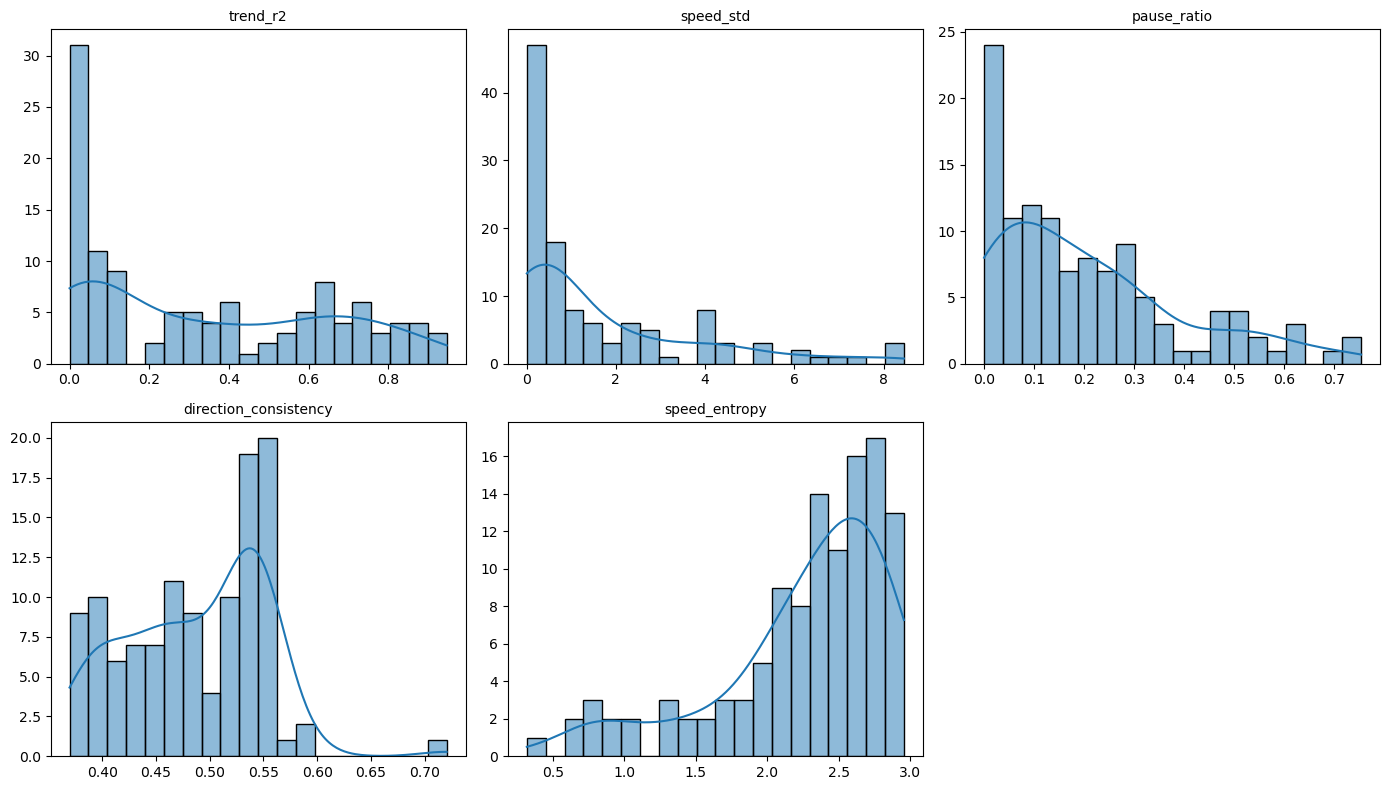

In [38]:
linear_like_feats = [
    "trend_r2", "speed_std", "pause_ratio",
    "direction_consistency", "speed_entropy"
]

n_feats = len(linear_like_feats)
n_cols = 3
n_rows = int(np.ceil(n_feats / n_cols))

plt.figure(figsize=(14, 8))

for i, feat in enumerate(linear_like_feats, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(df[feat], kde=True, bins=20)
    plt.title(f"{feat}", fontsize=10)
    plt.xlabel("")
    plt.ylabel("")

plt.tight_layout()
plt.show()

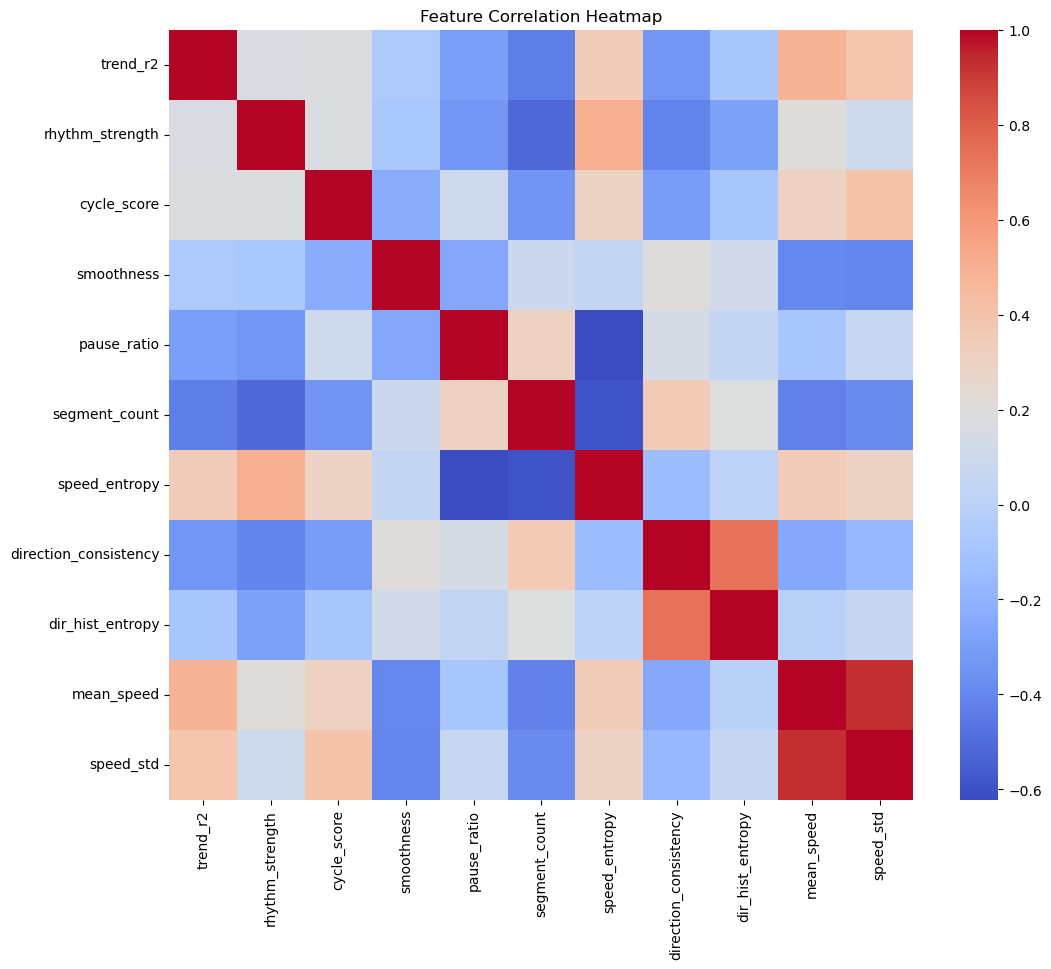

In [39]:
features = [
    "trend_r2", "rhythm_strength", "cycle_score", "smoothness",
    "pause_ratio", "segment_count", "speed_entropy", 
    "direction_consistency", "dir_hist_entropy",
    "mean_speed", "speed_std"
]

plt.figure(figsize=(12, 10))
sns.heatmap(df[features].corr(), annot=False, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

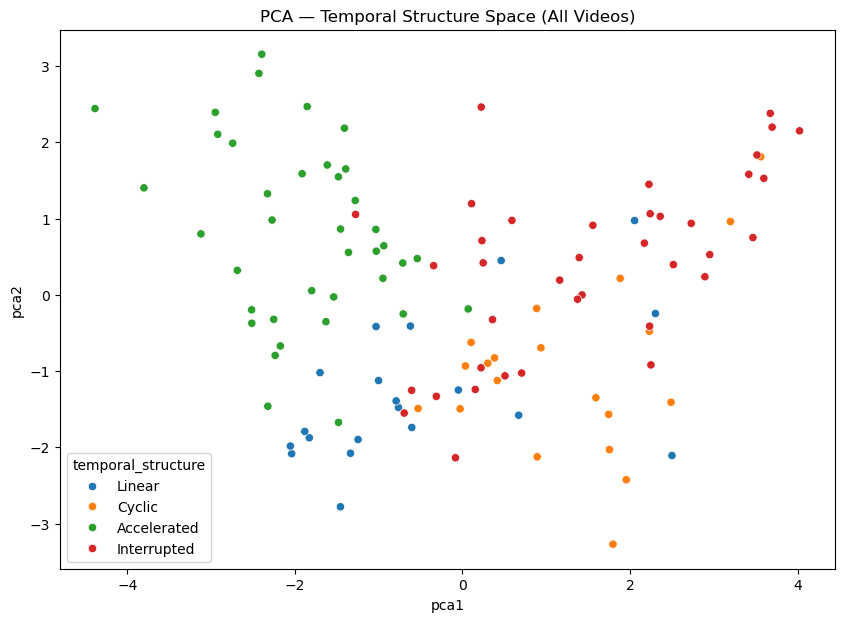

In [40]:
X = df[features].fillna(0)
X_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
pca_vals = pca.fit_transform(X_scaled)

df["pca1"] = pca_vals[:,0]
df["pca2"] = pca_vals[:,1]

plt.figure(figsize=(10,7))
sns.scatterplot(data=df, x="pca1", y="pca2", hue="temporal_structure", palette="tab10")
plt.title("PCA — Temporal Structure Space (All Videos)")
plt.show()

In [41]:
lin = df[df.temporal_structure=="Linear"].trend_r2
nonlin = df[df.temporal_structure!="Linear"].trend_r2

ks_stat, p = ks_2samp(lin, nonlin)
print("KS-test (Linear vs Others trend_r2):", ks_stat, p)

KS-test (Linear vs Others trend_r2): 0.32916666666666666 0.04256697188275401


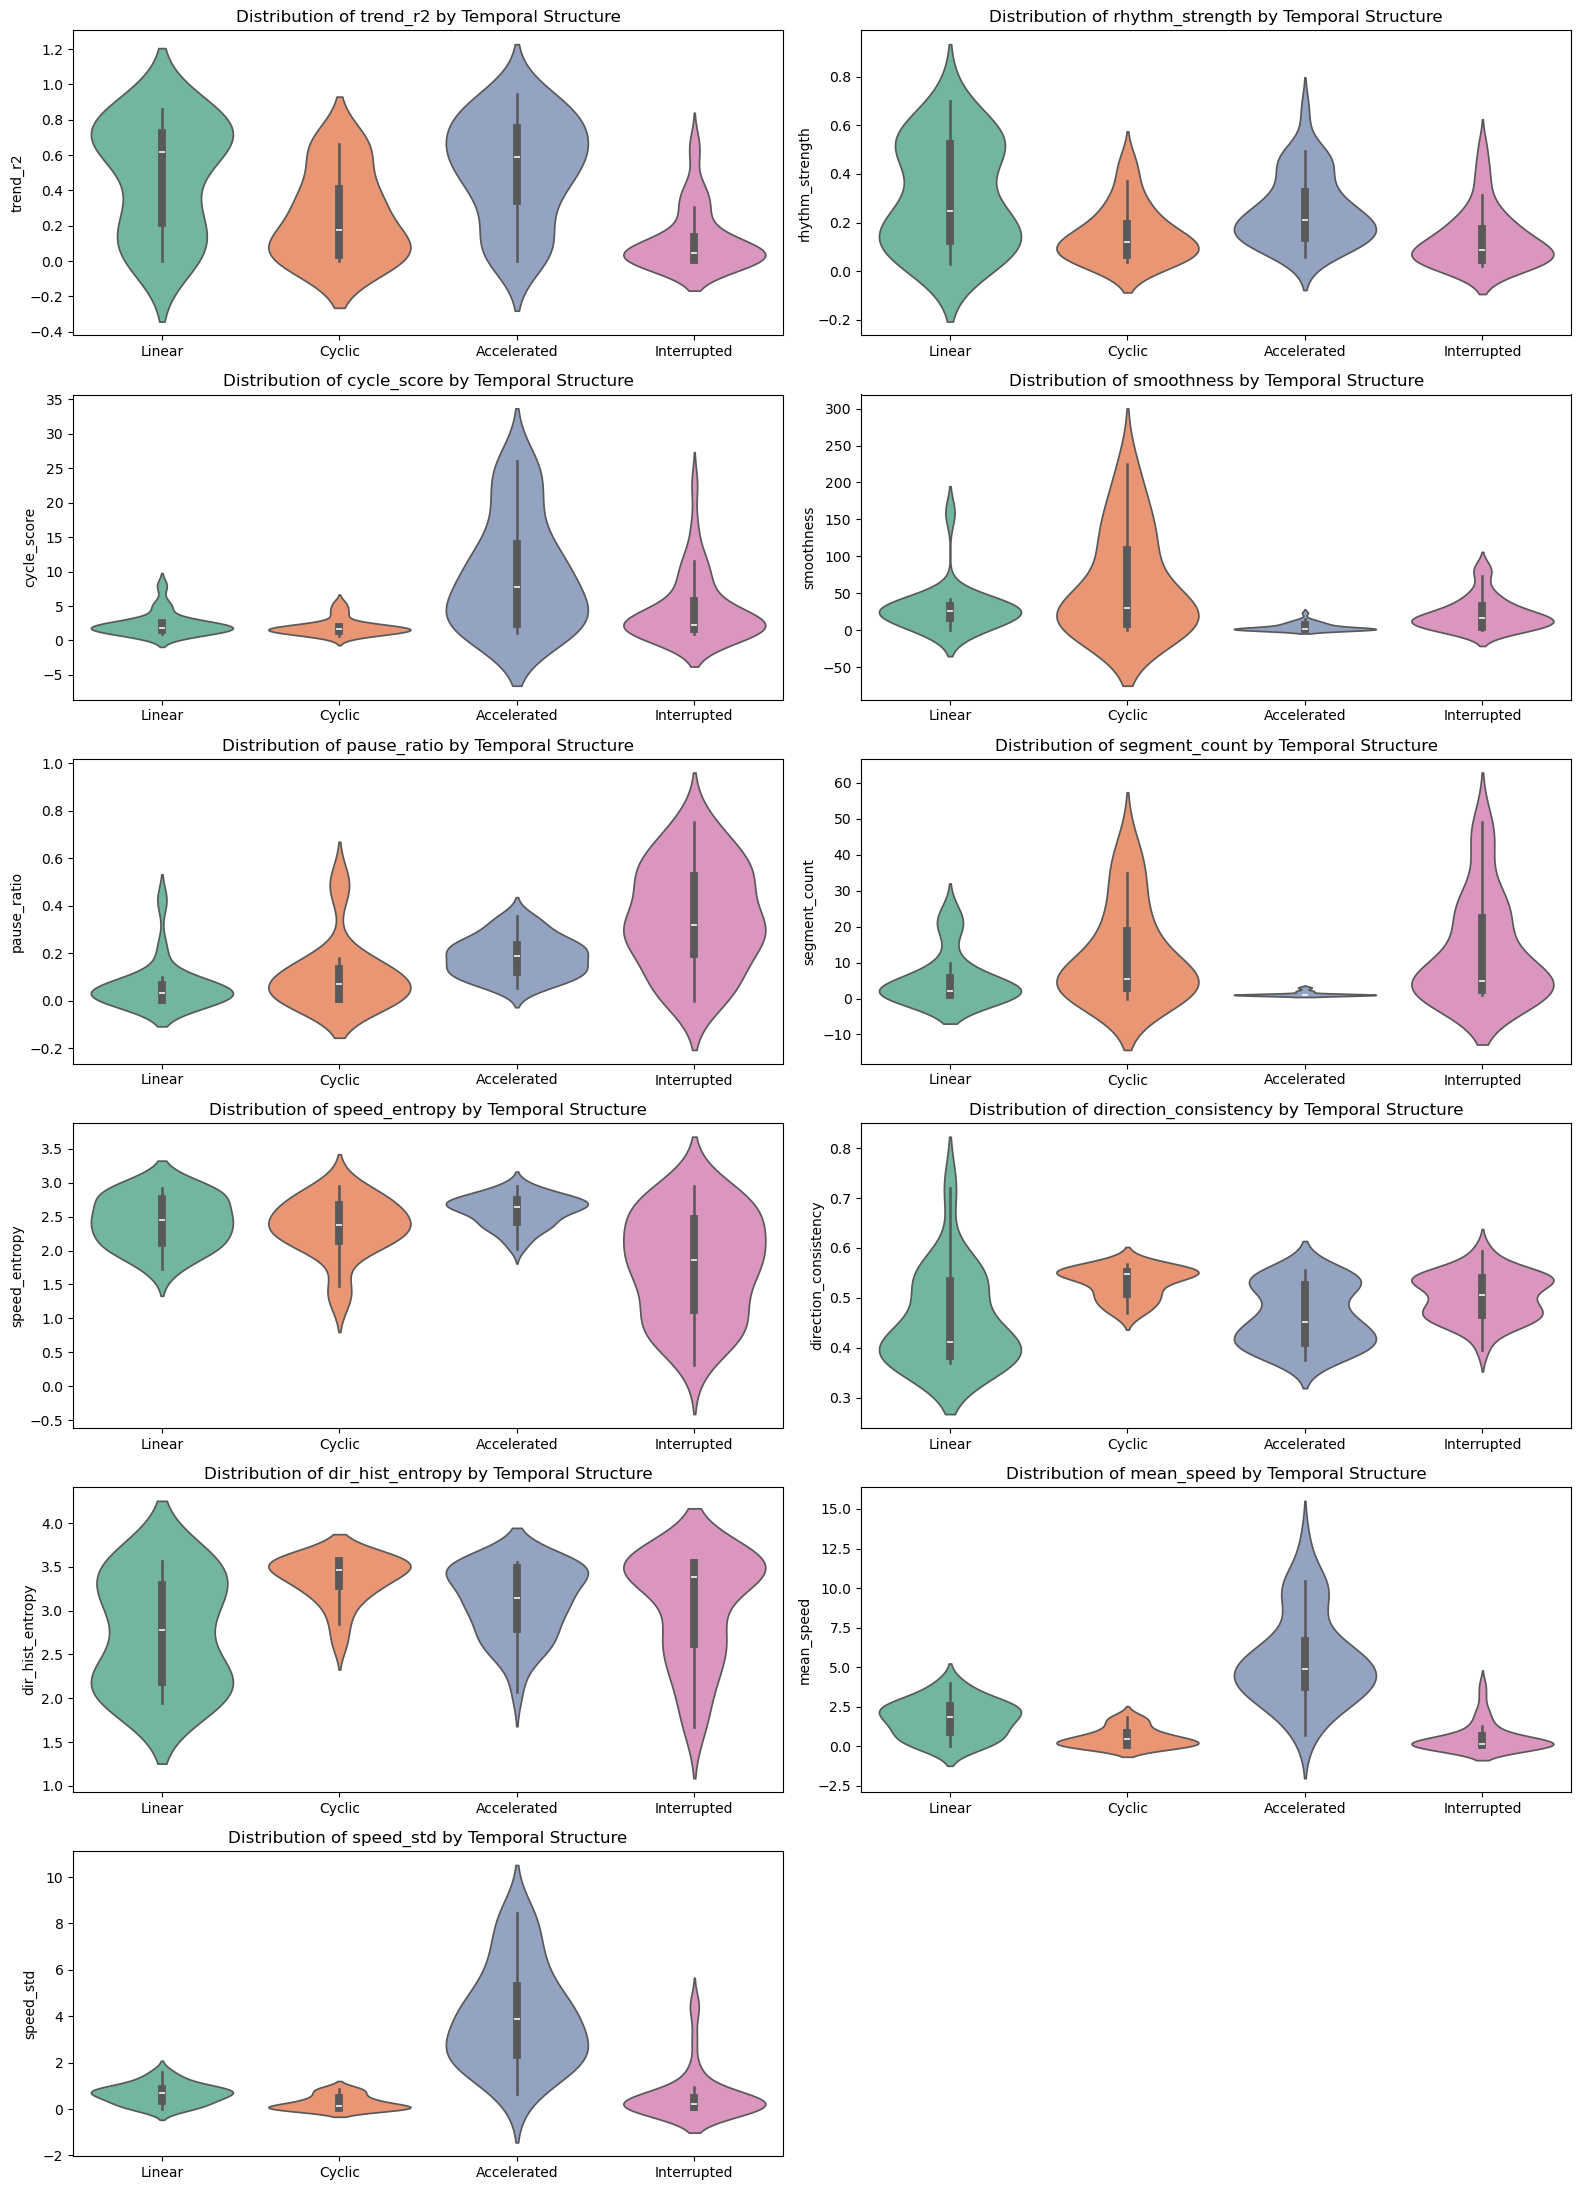

In [42]:
features_to_plot = [
    "trend_r2", "rhythm_strength", "cycle_score", "smoothness",
    "pause_ratio", "segment_count", "speed_entropy",
    "direction_consistency", "dir_hist_entropy",
    "mean_speed", "speed_std"
]

plt.figure(figsize=(16, 22))
for i, feat in enumerate(features_to_plot, 1):
    plt.subplot(len(features_to_plot)//2 + 1, 2, i)
    sns.violinplot(
    data=df,
    x="temporal_structure",
    y=feat,
    hue="temporal_structure",
    palette="Set2",
    legend=False
 )
    plt.title(f"Distribution of {feat} by Temporal Structure")
    plt.xlabel("")
plt.tight_layout()
plt.show()

c:\Users\lixin\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


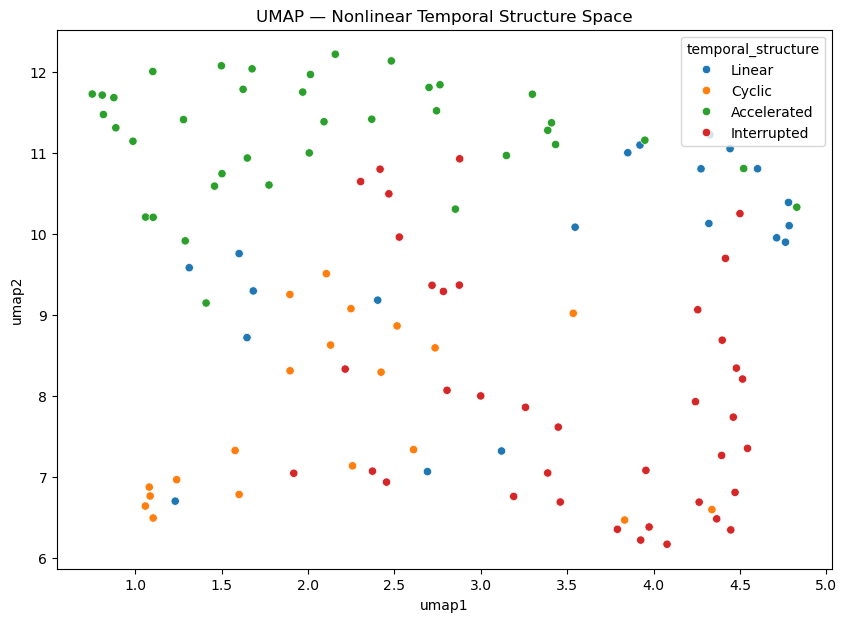

In [43]:
X = df[features].fillna(0)
X_scaled = StandardScaler().fit_transform(X)

reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    metric="euclidean",
    random_state=42
)

reducer.fit(X_scaled)
umap_vals = reducer.transform(X_scaled)

df["umap1"] = umap_vals[:, 0]
df["umap2"] = umap_vals[:, 1]

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=df, x="umap1", y="umap2",
    hue="temporal_structure", palette="tab10"
)
plt.title("UMAP — Nonlinear Temporal Structure Space")
plt.show()

### 1A

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [45]:
df_1A = df.iloc[:80].copy()

              precision    recall  f1-score   support

 Accelerated       1.00      0.75      0.86         4
      Cyclic       0.71      0.83      0.77         6
 Interrupted       0.71      1.00      0.83         5
      Linear       0.67      0.40      0.50         5

    accuracy                           0.75        20
   macro avg       0.77      0.75      0.74        20
weighted avg       0.76      0.75      0.74        20



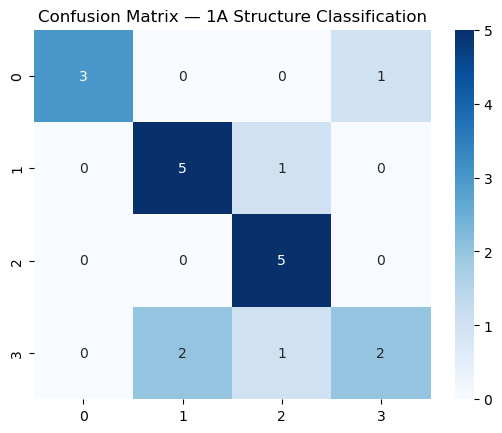

In [46]:
X = df_1A[features].fillna(0)
y = df_1A["temporal_structure"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

clf = RandomForestClassifier(n_estimators=300, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues")
plt.title("Confusion Matrix — 1A Structure Classification")
plt.show()

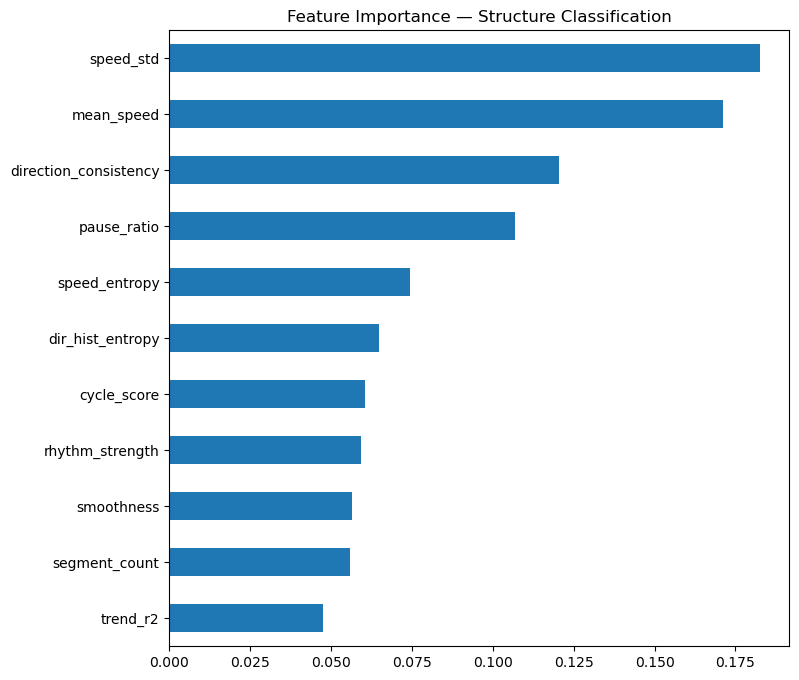

In [47]:
importances = pd.Series(clf.feature_importances_, index=features)
importances.sort_values().plot(kind='barh', figsize=(8,8))
plt.title("Feature Importance — Structure Classification")
plt.show()

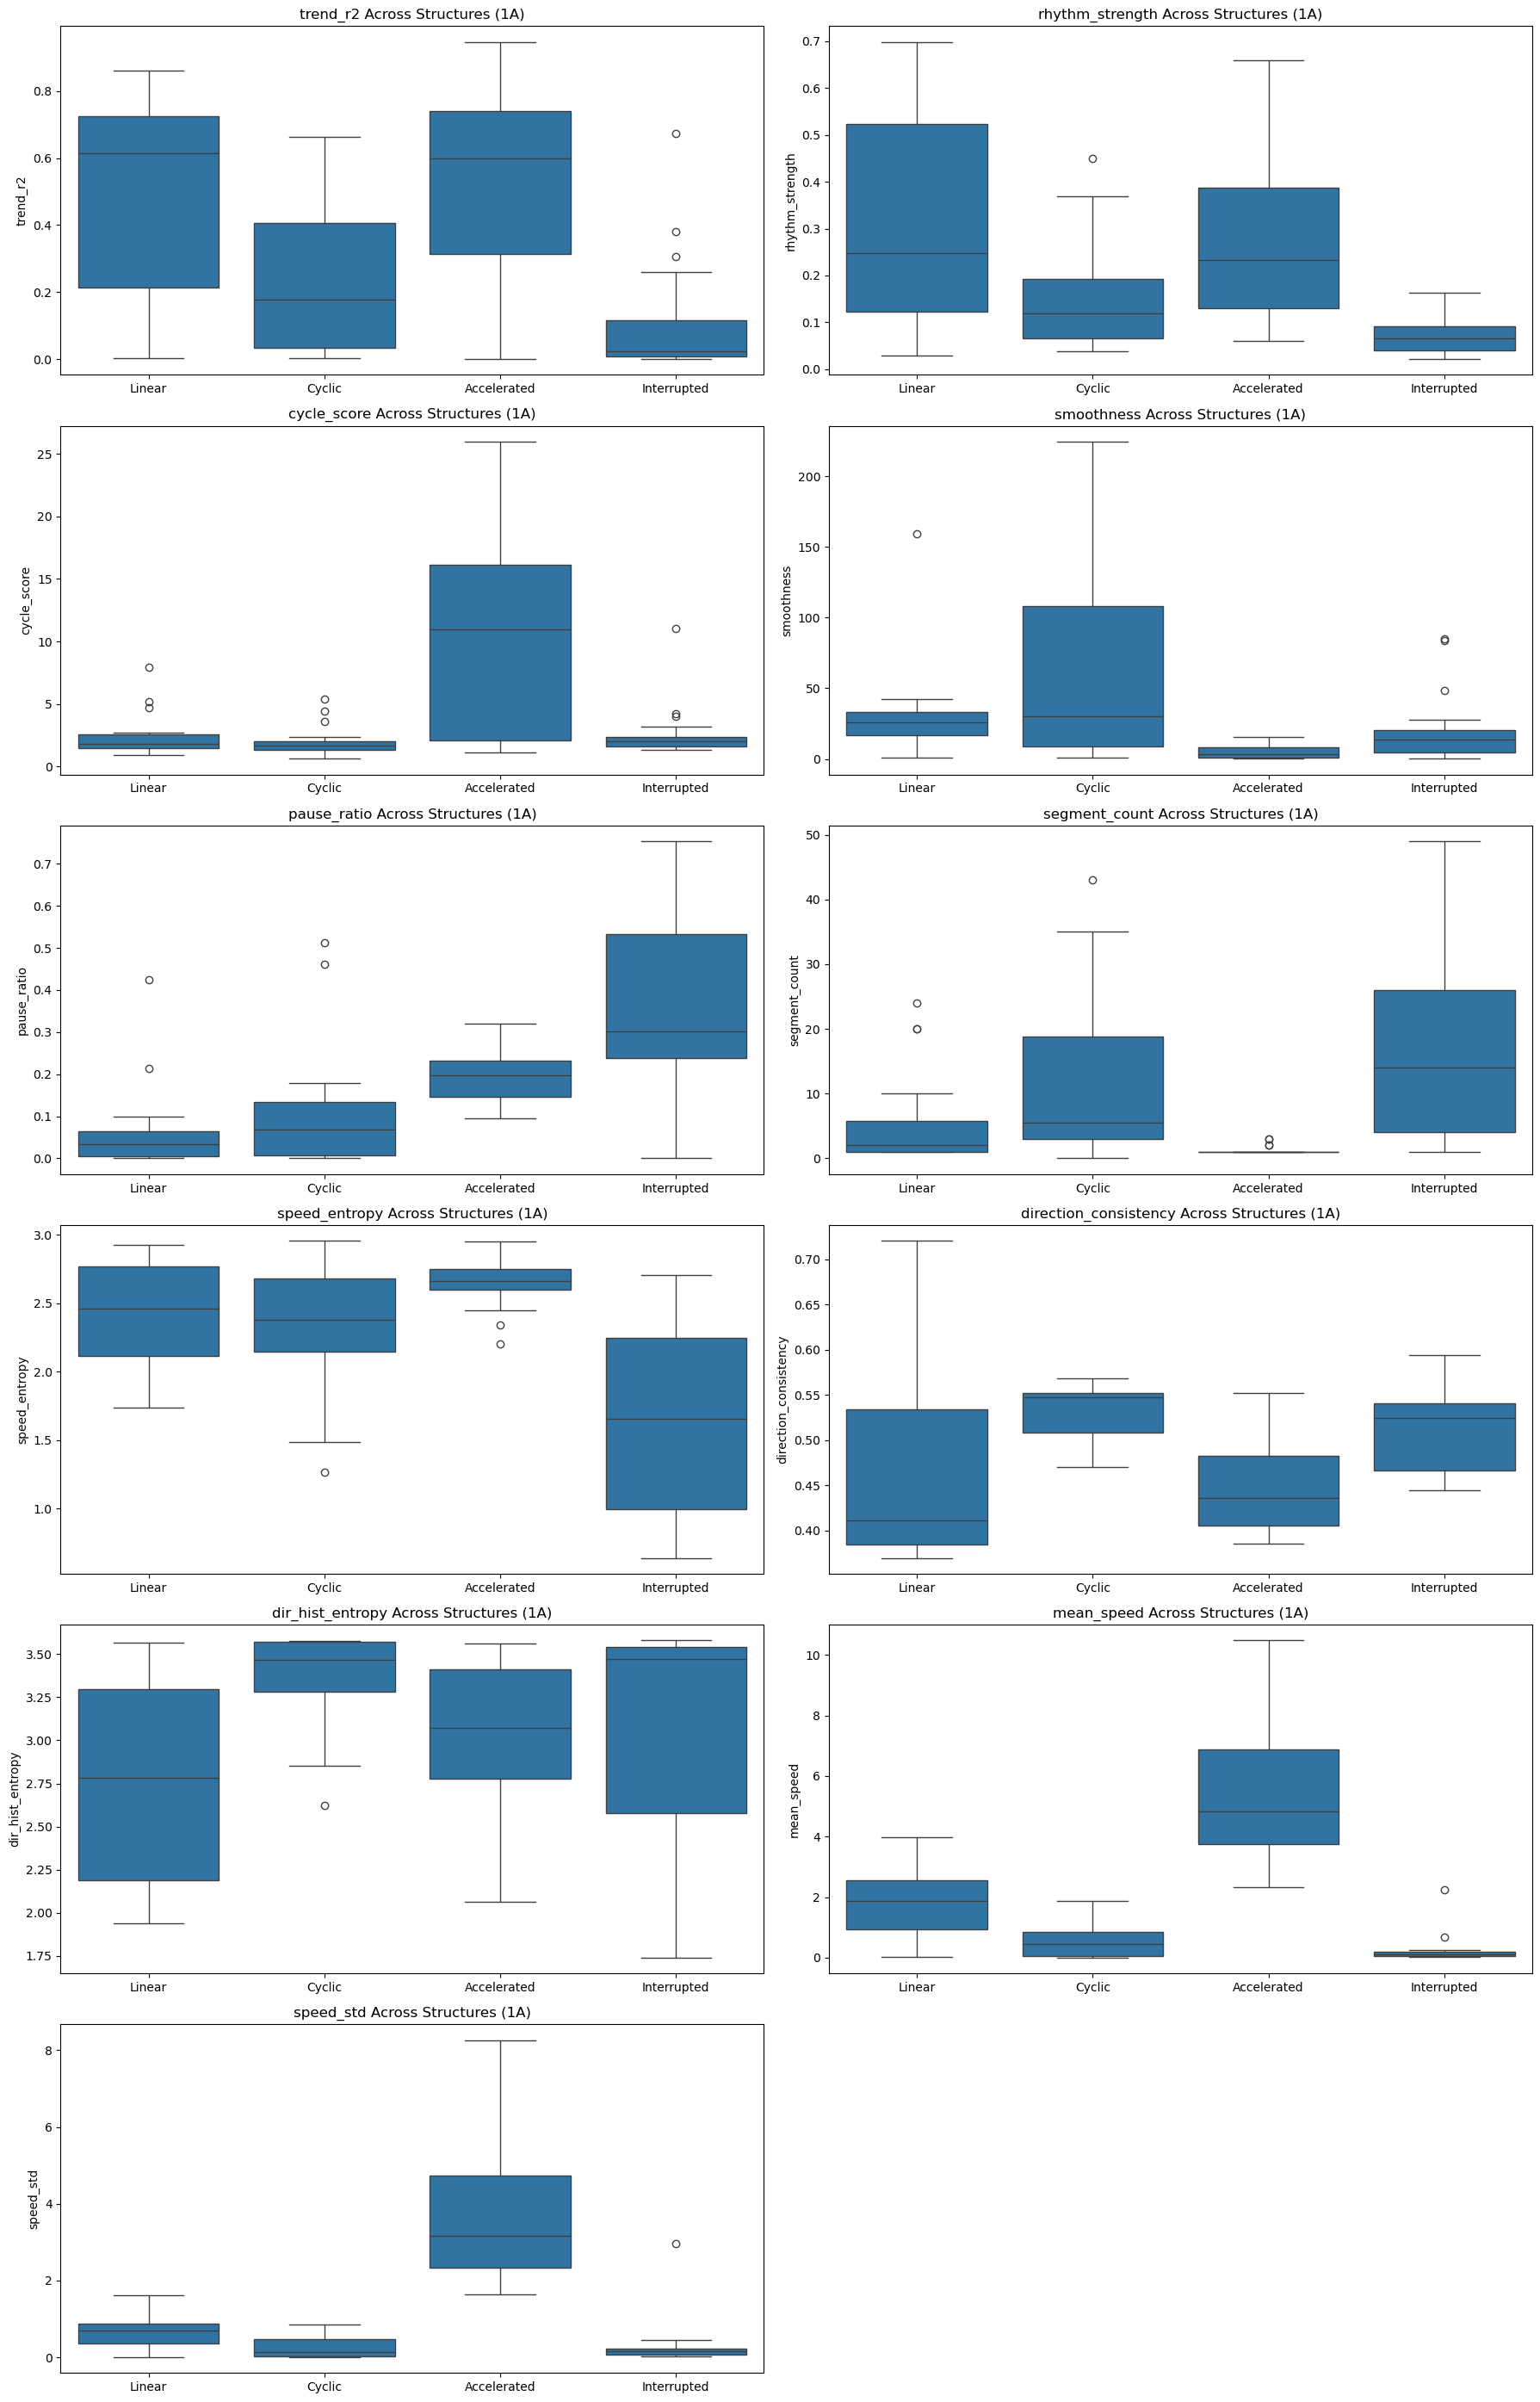

In [48]:
features_to_plot = features

plt.figure(figsize=(18, 28))

for i, feat in enumerate(features_to_plot, 1):
    plt.subplot(len(features_to_plot)//2 + 1, 2, i)
    sns.boxplot(data=df_1A, x="temporal_structure", y=feat)
    plt.title(f"{feat} Across Structures (1A)")
    plt.xlabel("")
plt.tight_layout()
plt.show()

In [49]:
from scipy.stats import f_oneway

for feat in features:
    groups = [df_1A[df_1A.temporal_structure==s][feat] 
              for s in df_1A.temporal_structure.unique()]
    stat, p = f_oneway(*groups)
    print(feat, p)

trend_r2 5.294665779674749e-06
rhythm_strength 5.6200170636116935e-06
cycle_score 9.445050536271765e-09
smoothness 0.00013863341107970376
pause_ratio 1.0380426381236995e-07
segment_count 2.8363777295478267e-05
speed_entropy 5.120809951674235e-09
direction_consistency 5.1356140043954997e-05
dir_hist_entropy 0.0030575691872257366
mean_speed 2.3059828650467667e-18
speed_std 2.102642355744118e-17


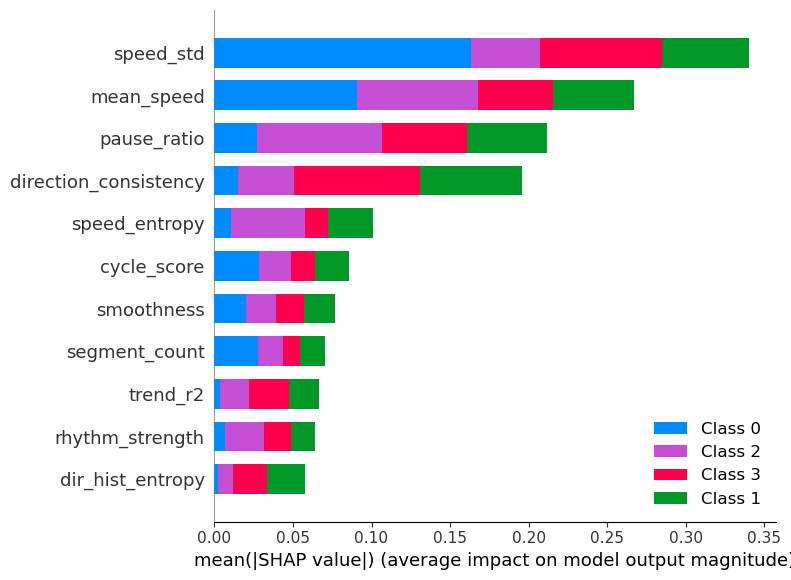

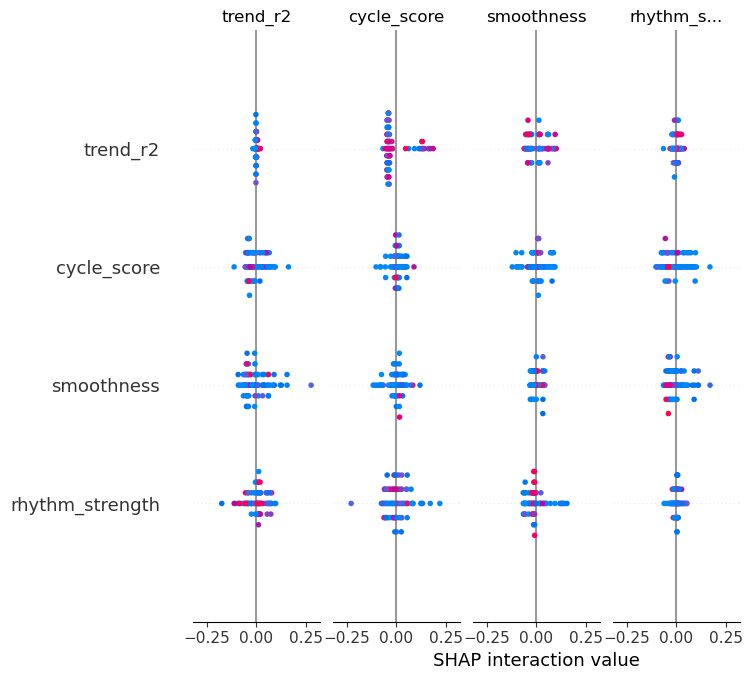

In [50]:
import shap

X = df_1A[features].fillna(0)
y = df_1A["temporal_structure"]

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, random_state=42)
clf.fit(X, y)

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X, plot_type="bar")

shap.summary_plot(shap_values, X)

In [51]:
print(clf.classes_)

['Accelerated' 'Cyclic' 'Interrupted' 'Linear']


c:\Users\lixin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


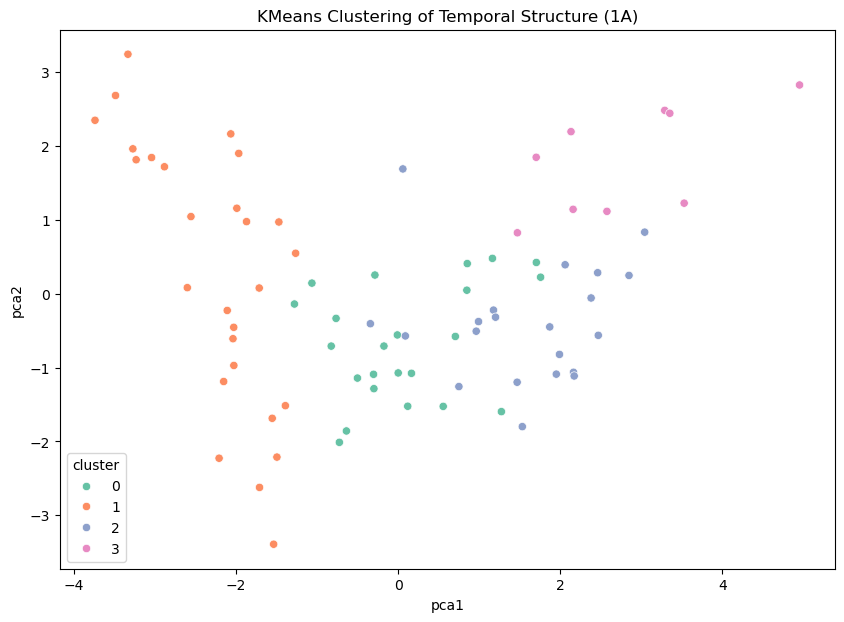

In [52]:
from sklearn.cluster import KMeans

X = df_1A[features].fillna(0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

df_1A["cluster"] = clusters

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_vals = pca.fit_transform(X_scaled)

df_1A["pca1"] = pca_vals[:, 0]
df_1A["pca2"] = pca_vals[:, 1]

plt.figure(figsize=(10,7))
sns.scatterplot(data=df_1A, x="pca1", y="pca2", hue="cluster", palette="Set2")
plt.title("KMeans Clustering of Temporal Structure (1A)")
plt.show()

### 1B

In [53]:
df_1B = df[df["prompt_id"].fillna("").str.contains(r"^1B-", regex=True)]
df_1B = df_1B.reset_index(drop=True)

df_acc = df_1B[df_1B["temporal_structure"].eq("Accelerated")].reset_index(drop=True)
df_int = df_1B[df_1B["temporal_structure"].eq("Interrupted")].reset_index(drop=True)

In [54]:
from scipy.stats import kruskal

groups = [df_acc[df_acc.intention==s]["smoothness"]
          for s in df_acc.intention.unique()]

stat, p = kruskal(*groups)
print("Kruskal–Wallis p:", p)

for feat in features:
    groups = [df_acc[df_acc.intention==s][feat] for s in df_acc.intention.unique()]
    _, p = kruskal(*groups)
    print(feat, p)

Kruskal–Wallis p: 0.007707995779151396
trend_r2 0.44358515137282495
rhythm_strength 0.16901331540606657
cycle_score 0.6449409664697834
smoothness 0.007707995779151396
pause_ratio 0.2244208727893693
segment_count 0.9896373989149964
speed_entropy 0.31231509214805125
direction_consistency 0.37220738497041017
dir_hist_entropy 0.12839657289294906
mean_speed 0.01885909036375207
speed_std 0.0033401004888472287


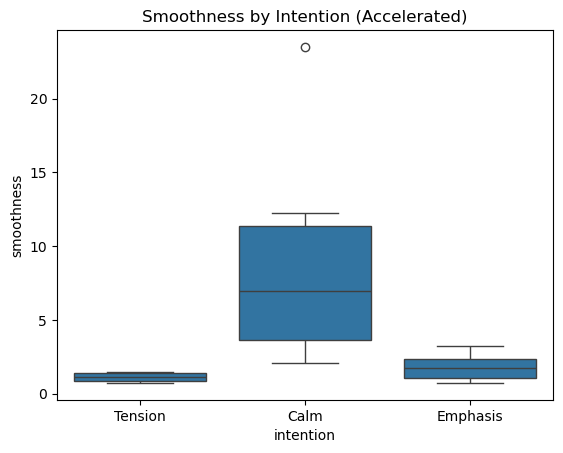

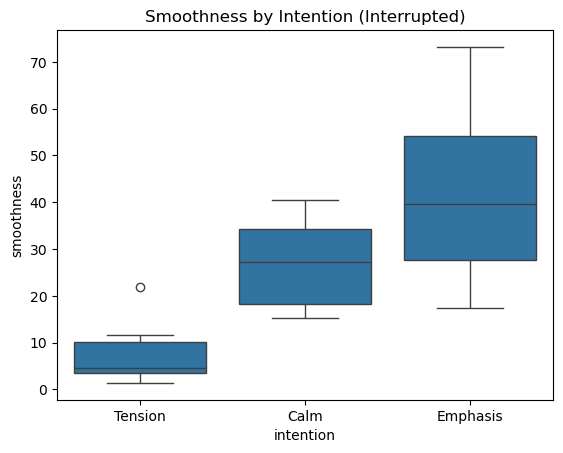

In [55]:
sns.boxplot(data=df_acc, x="intention", y="smoothness")
plt.title("Smoothness by Intention (Accelerated)")
plt.show()

sns.boxplot(data=df_int, x="intention", y="smoothness")
plt.title("Smoothness by Intention (Interrupted)")
plt.show()

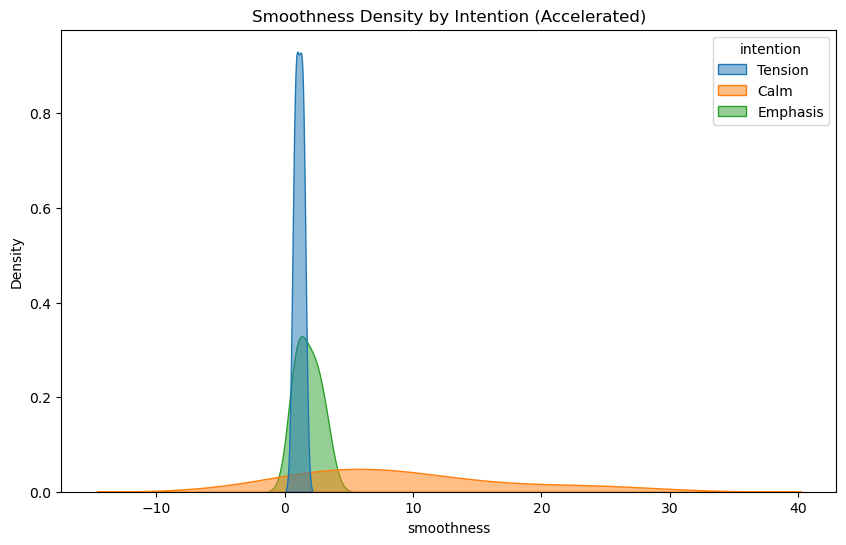

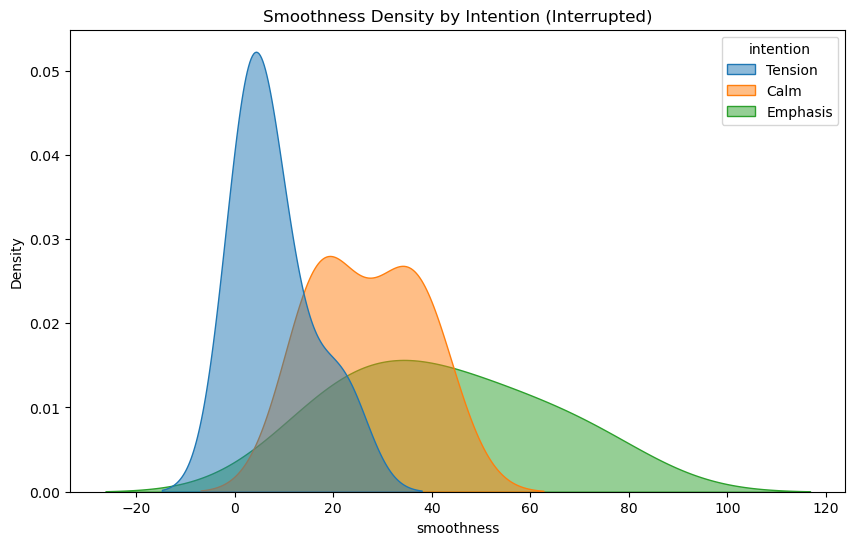

In [56]:
plt.figure(figsize=(10,6))
sns.kdeplot(
    data=df_acc,
    x="smoothness",
    hue="intention",
    fill=True,
    common_norm=False,
    alpha=0.5
)
plt.title("Smoothness Density by Intention (Accelerated)")
plt.show()

plt.figure(figsize=(10,6))
sns.kdeplot(
    data=df_int,
    x="smoothness",
    hue="intention",
    fill=True,
    common_norm=False,
    alpha=0.5
)
plt.title("Smoothness Density by Intention (Interrupted)")
plt.show()

### Bias

In [57]:
df_bias = df.iloc[:80].copy()
df_bias = df_bias.reset_index(drop=True)

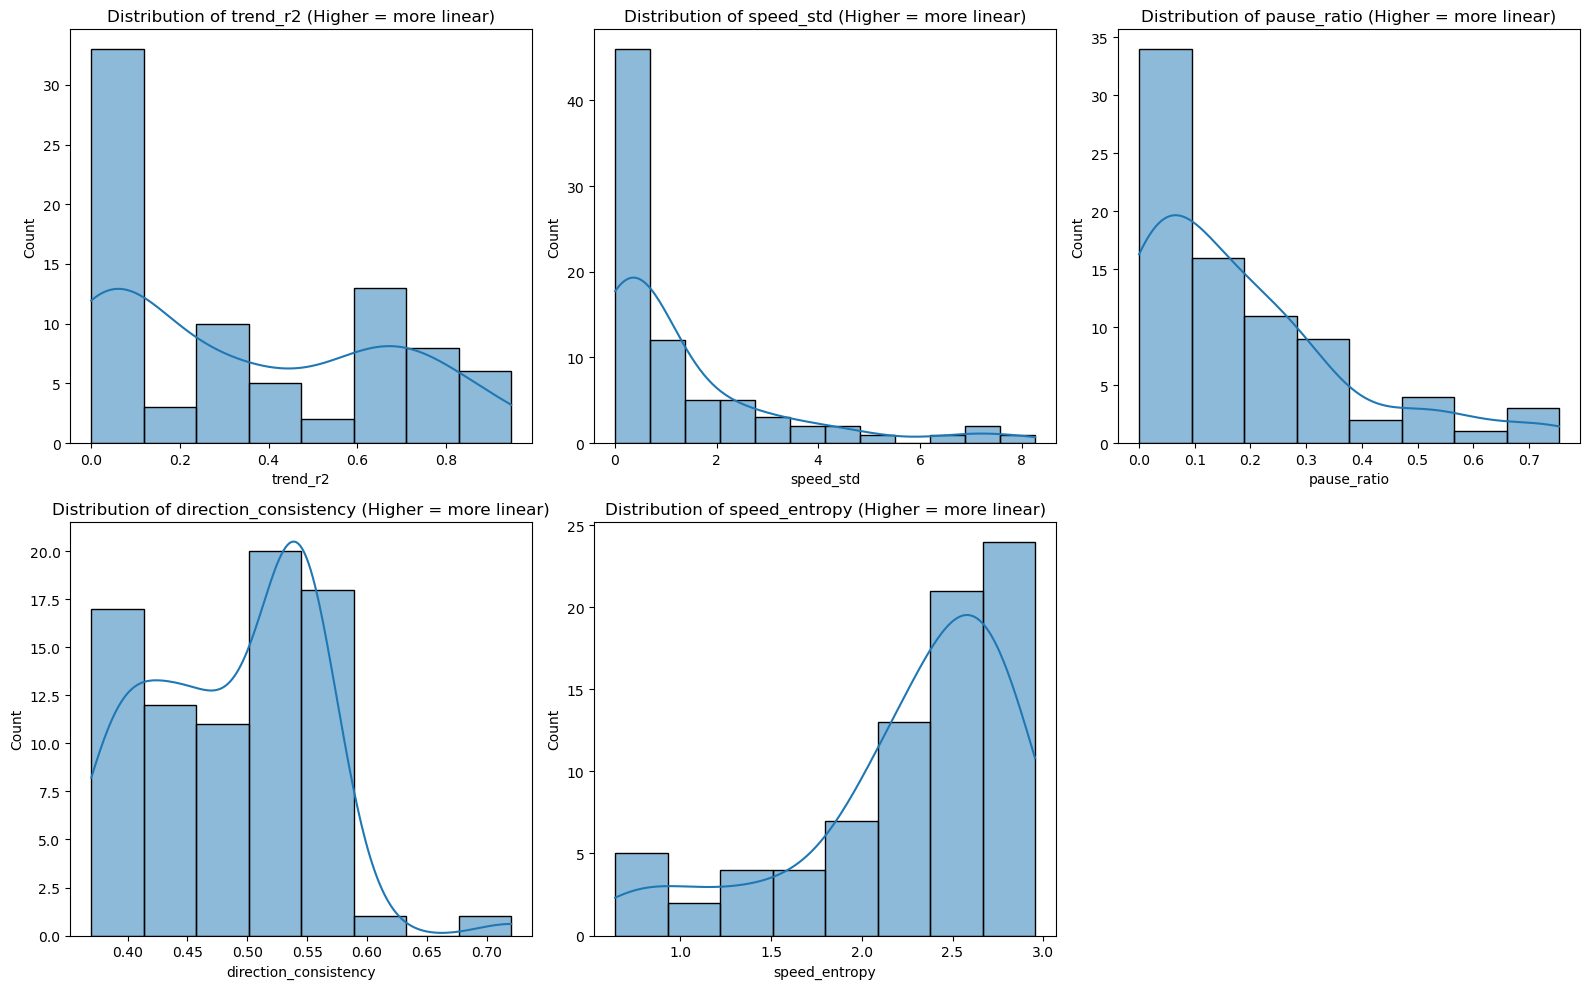

In [58]:
linear_like_feats = ["trend_r2", "speed_std", "pause_ratio",
                     "direction_consistency", "speed_entropy"]

plt.figure(figsize=(16, 10))
for i, feat in enumerate(linear_like_feats, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df_bias[feat], kde=True)
    plt.title(f"Distribution of {feat} (Higher = more linear)")
plt.tight_layout()
plt.show()

In [60]:
def extract_structure_from_id(pid):
    parts = pid.split('-')
    if len(parts) >= 2:
        return parts[1]
    return None

df_bias["prompt_base"] = df_bias["prompt_id"].apply(extract_structure_from_id)
print(df_bias["prompt_base"].unique())

['L' 'C' 'A' 'I']


prompt_base
A    0.438657
I    0.517011
C    0.563323
L    0.565042
Name: linearity_score, dtype: float64


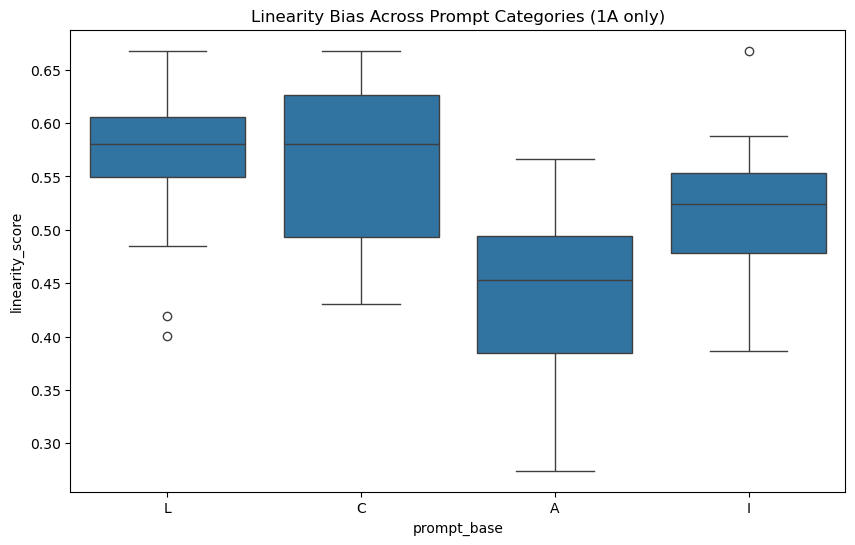

In [61]:
from sklearn.preprocessing import MinMaxScaler

linear_feats = ["trend_r2", "speed_std", "pause_ratio",
                "direction_consistency", "speed_entropy"]

df_scaled = df_bias[linear_feats].copy()

df_scaled["speed_std"] = -df_scaled["speed_std"]
df_scaled["pause_ratio"] = -df_scaled["pause_ratio"]
df_scaled["speed_entropy"] = -df_scaled["speed_entropy"]

scaler_mm = MinMaxScaler()
df_bias["linearity_score"] = scaler_mm.fit_transform(df_scaled).mean(axis=1)

bias_summary = df_bias.groupby("prompt_base")["linearity_score"].mean().sort_values()
print(bias_summary)

plt.figure(figsize=(10,6))
sns.boxplot(data=df_bias, x="prompt_base", y="linearity_score")
plt.title("Linearity Bias Across Prompt Categories (1A only)")
plt.show()

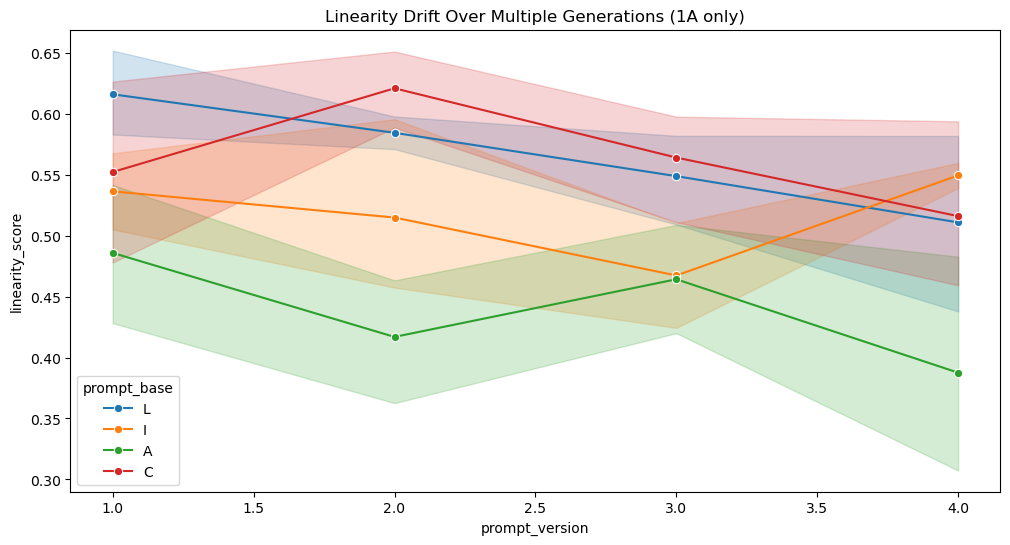

In [62]:
df_bias["prompt_version"] = df_bias["prompt_id"].str.extract(r"-(\d+)$").astype(int)

plt.figure(figsize=(12,6))
sns.lineplot(
    data=df_bias.sort_values("prompt_version"),
    x="prompt_version", y="linearity_score",
    hue="prompt_base", marker="o"
)
plt.title("Linearity Drift Over Multiple Generations (1A only)")
plt.show()

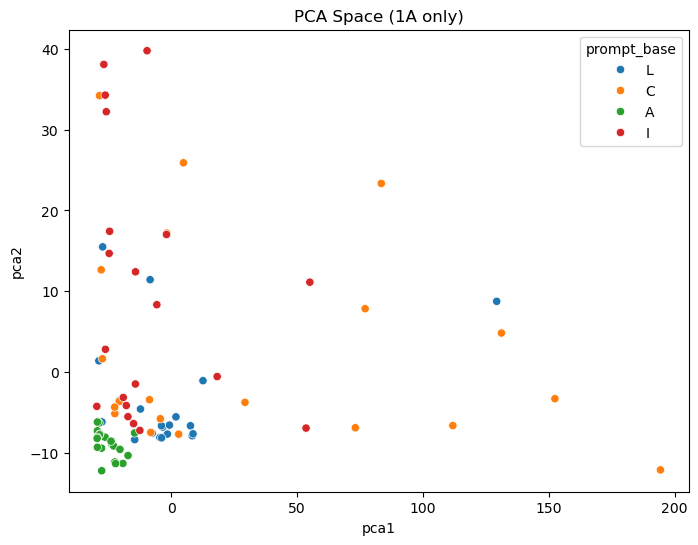

Separability score (1A only): 0.10291192207421225


In [63]:
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

X = df_bias[features].fillna(0)
pca = PCA(n_components=2).fit_transform(X)

df_bias["pca1"] = pca[:,0]
df_bias["pca2"] = pca[:,1]

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_bias, x="pca1", y="pca2", hue="prompt_base")
plt.title("PCA Space (1A only)")
plt.show()

X_scaled = StandardScaler().fit_transform(df_bias[features].fillna(0))
score = silhouette_score(X_scaled, df_bias["prompt_base"])
print("Separability score (1A only):", score)